In [1]:
import numpy as np
import pandas as pd
import json
from gensim.models import KeyedVectors
import re
import nltk
import nltk.data
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import word2vec
from gensim import models
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix
from gensim.models.keyedvectors import KeyedVectors
from langdetect import detect
import matplotlib.pyplot as plt

C:\Users\maria\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
C:\Users\maria\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
filename_b= 'BioWordVec_PubMed_MIMICIII_d200.vec.bin'
model_b= KeyedVectors.load_word2vec_format(filename_b, binary=True)

## Importación de los documentos

In [3]:
def leer_fichero(filename, num_documentos=10000):
    SKIP = 4
    registros = []
    with open(filename,"r") as f:
        i = 1 # número de línea que se está leyendo
        line = f.readline()
        while line:
            i += 1
            line = f.readline()

            # Saltar las primeras SKIP líneas
            if i <= SKIP:
                continue

            json_str = line[1:-1] # quitamos los primer y último caracteres
            try:
                registros.append(json.loads(json_str))
            except json.JSONDecodeError:
                pass

            # Salir cuando hayamos cargado num_documentos documentos
            if len(registros) == num_documentos:
                break
    return registros

In [4]:
filename = "litcovid2BioCJSON.json"
registros = leer_fichero(filename, num_documentos=1000000)

In [5]:
# Extraer texto de unos determinados passages
def extrae_texto(registro):
    to_exclude = [
        'fig', 'fig_caption','fig_footnote','fig_title_caption', 
        'ref', 
        'table', 'table_caption', 'table_foot', 'table_foot_title','table_footnote', 'table_title_caption', 
        'footnote',
        'abstract', 'abstract_title_1',
        ]
    return [passage['text'] for passage in registro['passages'] if passage['infons']['type'] not in to_exclude]
# Extraer abstract
def extrae_abstract(registro):
    return [passage['text'] for passage in registro['passages'] if passage['infons']['type'] in ['abstract']]

In [6]:
textos = pd.Series({r['_id'][:8]: " ".join(extrae_texto(r)) for r in registros})

In [7]:
#seleccionamos los artículos con al menos 300 palabras
mask = (textos.str.len() > 300)
testos = textos.loc[mask]

In [8]:
#cargamos los datos que contienen los abstracts y palabras clave
data =pd.read_csv('train.csv')
data_test=pd.read_csv('test.csv')
result = pd.concat([data, data_test], axis=0)

In [9]:
# nos quedamos con solo 3 columnas y con los abstracts que tengan al menos 350 palabras
result= result[['pmid','keywords','abstract']]
result=result[result['abstract'].str.len()>350]
result=result.reset_index().drop(columns='index')

In [10]:
testos=pd.DataFrame(testos,columns=['testoss'])
testos['pmid']=testos.index
testos['pmid'] = pd.Series(testos['pmid'], dtype="string")
result['pmid']=result['pmid'].astype(str)
result['pmid'] = pd.Series(result['pmid'], dtype="string")
datax=result.merge(testos,how='inner',on='pmid')
datax=datax.dropna()
datax=datax.reset_index().drop(columns='index')

In [11]:
#detectamos el idioma del texto
for i in range(1,12777):
    lang = detect(datax['testoss'][i])
    datax['lang']=lang

In [12]:
datax['lang'].unique()

array(['en'], dtype=object)

### TF-IDF texto completo

In [13]:
#definimos las stop words
stop_words = set(stopwords.words("english"))
##Creamos una lista de stopwords customizadas
new_words = ["ha", "become", "put", "large", "also", "since", "one", "two", "new", "previously", "shown","ng","background","describe","recent","despite","wa","objective"]
stop_words = stop_words.union(new_words)

In [14]:
corpus = []
for i in range(0, 1000):
    #Eliminamos las  puntuaciones
    text = re.sub('[^a-zA-Z]', ' ', datax['testoss'][i])
    
    #Convertimos a minusculas
    text = text.lower()
    
    #eliminamos tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # eliminamos caracteres especiales o dígitos
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    tagged = nltk.pos_tag(text)

    x1 = [(i,j.replace('VBD','r').replace('NNS','n').replace('NN','n').replace('JJ','a').replace('VB','v').replace('vP','v').replace('vN','v').replace('IN','n').replace('RB','a').replace('DT','n').replace('MD','v').replace('aR','n').replace('CC','n').replace('vG','v').replace('TO','n').replace('vZ','v').replace('CD','n').replace('aS','r').replace('W','n').replace('PRP','n').replace('EX','n').replace('Fn','n').replace('nP','n').replace('RP','n').replace('na','n').replace('Pn','n').replace('n$','n').replace('nn','n').replace('nS','n').replace('UH','n').replace('$','n').replace('POS','n').replace('SYM','n').replace('','n').replace('nnn','n').replace('nan','n').replace('nvn','n').replace('nrn','n').replace("n'n'n",'n')) for i,j in tagged]

    ##Remove stop words
    text1=[]
    for word in text:
        if word not in stop_words:
            text1.append(word)
     #Lemmatisation
    lem = WordNetLemmatizer()
    text2 = []
    for word in text1:
        if word not in stop_words:
            text2.append(lem.lemmatize(word, pos=x1[text.index(word)][1]))
#     text = [lem.lemmatize(word, pos=x1[i][1]) for word in text if not word in stop_words] 
    text2 = " ".join(text2)
    corpus.append(text2)

In [15]:
cv=CountVectorizer(max_df=0.85,stop_words=stop_words, max_features=1000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [16]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)# get feature names
feature_names=cv.get_feature_names()

In [17]:
#Function for sorting tf_idf in descending order
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [18]:
keys150tf_0=[]
for i in range(0, 1000):
    # fetch document for which keywords needs to be extracted
    doc=corpus[i]
 
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))#sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())#extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    # now print the results
    keys150tf_0.append(keywords)

In [19]:
#convertimos al formato que queremos el resultado que nos ha devuelto la matriz
keys150tf_1=[]
for i in keys150tf_0:
    k1=list(i)
    keys150tf_1.append(k1)
keys150tf = []
for i in range(0,1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', str(keys150tf_1[i]))
    ##Convert to list from string
    text = text.split()
    keys150tf.append(text)

In [20]:
#convertimos al mismo formato las palabras dadas por los autores
keys2=[]
for i in range(0, 1000):
    k=datax['keywords'][i]
    keys2.append(k)
keys3=[]
for i in range(0, 1000):    
    k3=str(keys2[i]).split(';')
    keys3.append(k3)
keys4 = []
for i in range(0, 1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', str(keys3[i]))
    
    ##Convert to list from string
    text = text.split()
    
    ##Lemmatization
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    keys4.append(text)

In [21]:
def evaluate_keywords(proposed,groundtruth):

    proposed_set = set(proposed)
#     print(proposed_set)
    true_set = set(groundtruth)
#     print(true_set)
    true_positives = len(proposed_set.intersection(true_set))
    if len(proposed_set)==0:
        precision = 0
    else:
        # note denominator reflects total number of words
        # not total number of unique words
        precision = true_positives/float(len(proposed)) 
        jaccard= float(len(proposed_set.intersection(true_set)) / len(proposed_set.union(true_set)))

    if len(true_set)==0:
        recall = 0
    else:
        recall = true_positives/float(len(true_set))

    if precision + recall > 0:
        f1 = 2*precision*recall/float(precision + recall)
    else:
        f1 = 0
        

    return (precision, recall, f1, jaccard)

In [22]:
d=['s1_1','s2_1','s3_1','s4_1','s5_1','s6_1','s7_1','s8_1','s9_1','s10_1']

In [23]:
a=[]
al1=[]
al2=[]
al3=[]
al4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=keys150tf[j][:i]
        e=evaluate_keywords(keys4[j],lista)
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    al1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    al2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    al3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    al4.append(aa4)


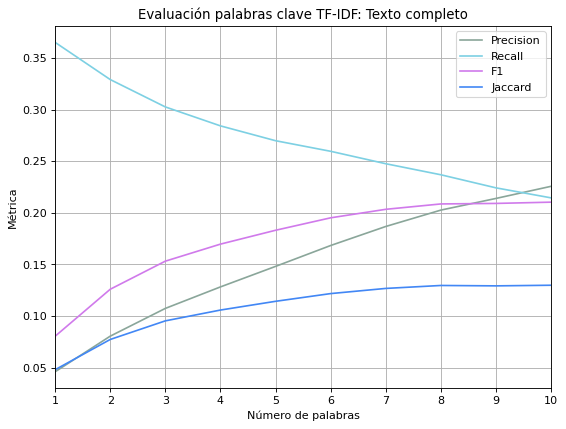

In [24]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,al1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,al2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,al3, 'b', label='F1',c='#d07aeb')
plt.plot(x,al4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave TF-IDF: Texto completo')
plt.show()

## Texto primeras 150 palabras - TF -IDF

In [25]:
corpus = []
for i in range(0, 1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', datax['testoss'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    tagged = nltk.pos_tag(text)

    x1 = [(i,j.replace('VBD','r').replace('NNS','n').replace('NN','n').replace('JJ','a').replace('VB','v').replace('vP','v').replace('vN','v').replace('IN','n').replace('RB','a').replace('DT','n').replace('MD','v').replace('aR','n').replace('CC','n').replace('vG','v').replace('TO','n').replace('vZ','v').replace('CD','n').replace('aS','r').replace('W','n').replace('PRP','n').replace('EX','n').replace('Fn','n').replace('nP','n').replace('RP','n').replace('na','n').replace('Pn','n').replace('n$','n').replace('nn','n').replace('nS','n').replace('UH','n').replace('$','n').replace('POS','n').replace('SYM','n').replace('','n').replace('nnn','n').replace('nan','n').replace('nvn','n').replace('nrn','n').replace("n'n'n",'n')) for i,j in tagged]

    ##Remove stop words
    text1=[]
    for word in text:
        if word not in stop_words:
            text1.append(word)
     #Lemmatisation
    lem = WordNetLemmatizer()
    text2 = []
    for word in text1:
        if word not in stop_words:
            text2.append(lem.lemmatize(word, pos=x1[text.index(word)][1]))
#     text = [lem.lemmatize(word, pos=x1[i][1]) for word in text if not word in stop_words] 
    text2=text2[:150]
    text2 = " ".join(text2)
    corpus.append(text2)

In [26]:
cv=CountVectorizer(max_df=0.85,stop_words=stop_words, max_features=1000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [27]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)# get feature names
feature_names=cv.get_feature_names()

In [28]:
#Function for sorting tf_idf in descending order
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [29]:
keys_t1=[]
for i in range(0, 1000):
    # fetch document for which keywords needs to be extracted
    doc=corpus[i]
 
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))#sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())#extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    # now print the results
    keys_t1.append(keywords)


In [30]:
#convertimos al formato que queremos el resultado que nos ha devuelto la matriz
keys_t2=[]
for i in keys_t1:
    k1=list(i)
    keys_t2.append(k1)
keys_t = []
for i in range(0,1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', str(keys_t2[i]))
    ##Convert to list from string
    text = text.split()
    keys_t.append(text)

In [31]:
a=[]
am1=[]
am2=[]
am3=[]
am4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=keys_t[j][:i]
        e=evaluate_keywords(keys4[j],lista)
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    am1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    am2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    am3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    am4.append(aa4)

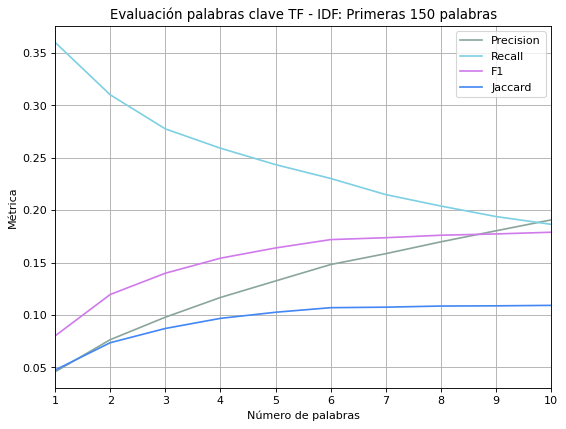

In [32]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,am1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,am2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,am3, 'b', label='F1',c='#d07aeb')
plt.plot(x,am4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave TF - IDF: Primeras 150 palabras')
plt.show()

## TF-IDF Abstract

In [33]:
corpus = []
for i in range(0, 1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', datax['abstract'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    tagged = nltk.pos_tag(text)

    x1 = [(i,j.replace('VBD','r').replace('NNS','n').replace('NN','n').replace('JJ','a').replace('VB','v').replace('vP','v').replace('vN','v').replace('IN','n').replace('RB','a').replace('DT','n').replace('MD','v').replace('aR','n').replace('CC','n').replace('vG','v').replace('TO','n').replace('vZ','v').replace('CD','n').replace('aS','r').replace('W','n').replace('PRP','n').replace('EX','n').replace('Fn','n').replace('nP','n').replace('RP','n').replace('na','n').replace('Pn','n').replace('n$','n').replace('nn','n').replace('nS','n').replace('UH','n').replace('$','n').replace('POS','n').replace('SYM','n').replace('','n').replace('nnn','n').replace('nan','n').replace('nvn','n').replace('nrn','n').replace("n'n'n",'n')) for i,j in tagged]

    ##Remove stop words
    text1=[]
    for word in text:
        if word not in stop_words:
            text1.append(word)
     #Lemmatisation
    lem = WordNetLemmatizer()
    text2 = []
    for word in text1:
        if word not in stop_words:
            text2.append(lem.lemmatize(word, pos=x1[text.index(word)][1]))
#     text = [lem.lemmatize(word, pos=x1[i][1]) for word in text if not word in stop_words] 
    text2=text2[:150]
    text2 = " ".join(text2)
    corpus.append(text2)

In [34]:
cv=CountVectorizer(max_df=0.85,stop_words=stop_words, max_features=1000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [35]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)# get feature names
feature_names=cv.get_feature_names()

In [36]:
#Function for sorting tf_idf in descending order
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [37]:
keys_a1=[]
for i in range(0, 1000):
    # fetch document for which keywords needs to be extracted
    doc=corpus[i]
 
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))#sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())#extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    # now print the results
    keys_a1.append(keywords)

In [38]:
#convertimos al formato que queremos el resultado que nos ha devuelto la matriz
keys_a2=[]
for i in keys_a1:
    k1=list(i)
    keys_a2.append(k1)
keys_a = []
for i in range(0,1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', str(keys_a2[i]))
    ##Convert to list from string
    text = text.split()
    keys_a.append(text)

In [40]:
a=[]
an1=[]
an2=[]
an3=[]
an4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=keys_t[j][:i]
        e=evaluate_keywords(keys4[j],lista)
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    an1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    an2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    an3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    an4.append(aa4)

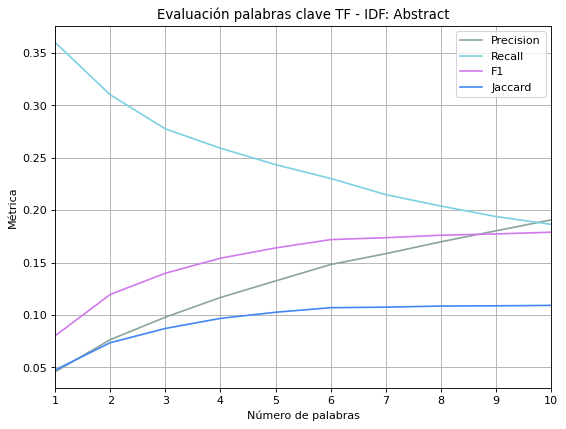

In [41]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,an1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,an2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,an3, 'b', label='F1',c='#d07aeb')
plt.plot(x,an4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave TF - IDF: Abstract')
plt.show()

### Entrenamiento propio modelo

In [42]:
# Function to convert a document to a sequence of words,
def text_to_wordlist(text, remove_stopwords=False):
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]", " ", text)

    # 3. Convert words to lower case and split them
    words = review_text.lower().split()

    return (words)


In [43]:
tokenizer = sent_tokenize
from nltk.tokenize import sent_tokenize

In [44]:
def text_to_sentences(text, tokenizer, remove_stopwords=False):
    # Function to split a text into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = nltk.sent_tokenize(text) # this gives us a list of sentences
    #
    # 2. Loop over each sentence
    sentences = []
    for sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(text_to_wordlist(sentence, remove_stopwords=False))

    return sentences

In [45]:
sentences = []

# Parsing sentences from training set
for i in range(0,12777):
    raw_sentences = nltk.sent_tokenize(datax['testoss'][i])
    for sentence in raw_sentences:
        sentences.append(text_to_wordlist(sentence, remove_stopwords=False))

In [46]:
num_features = 150
model = word2vec.Word2Vec(sentences, window=10, min_count=2,)
model_name = "w2v"
model.save(model_name)
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.

In [47]:
# model.init_sims(replace=True)
model = word2vec.Word2Vec.load(model_name)

### Extracción de palabras clave: Texto completo

In [48]:
def text_to_wordlist(text, remove_stopwords=True):
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]", " ", text)

    # 3. Convert words to lower case and split them, clean stopwords from model' vocabulary
    words = review_text.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    return (meaningful_words)

In [49]:
def get_feature_vec(words, model):
    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key )
    clean_text = []
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            clean_text.append(model.wv[word])

    return clean_text

In [50]:
def powerMethod(A, x0, m, iter):
    n = A.shape[1]

    delta = m * (np.array([1] * n, dtype='float64') / n)
    for i in range(iter):
        x0 = np.dot((1 - m), np.dot(A, x0)) + delta
    return x0

In [51]:
key_word_list_m=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in range(0, 10):
        keywords_list.append(clean_train_text[words])
 
    key_word_list_m.append(keywords_list)

In [52]:
a=[]
as1=[]
as2=[]
as3=[]
as4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_m[j][:i]
        e=evaluate_keywords(keys4[j],lista)
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    as1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    as2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    as3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    as4.append(aa4)

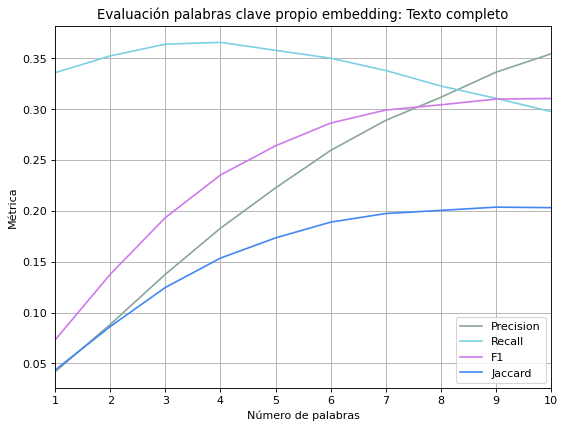

In [53]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,as1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,as2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,as3, 'b', label='F1',c='#d07aeb')
plt.plot(x,as4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave propio embedding: Texto completo')
plt.show()

## Propio-embedding abstract

In [54]:
key_word_list_ma=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['abstract'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in range(0, 10):
        keywords_list.append(clean_train_text[words])
 
    key_word_list_ma.append(keywords_list)

In [55]:
a=[]
aj1=[]
aj2=[]
aj3=[]
aj4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_ma[j][:i]
        e=evaluate_keywords(keys4[j],lista)
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    aj1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    aj2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    aj3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    aj4.append(aa4)


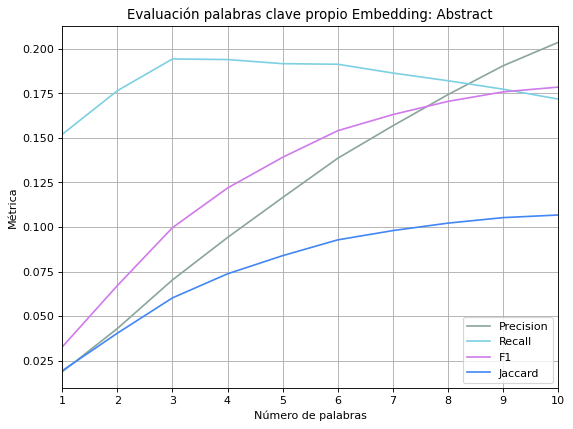

In [56]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,aj1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,aj2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,aj3, 'b', label='F1',c='#d07aeb')
plt.plot(x,aj4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave propio Embedding: Abstract')
plt.show()

### Modelo médico - Abstracts

In [57]:
def text_to_wordlist(text, remove_stopwords=True):
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]", " ", text)

    # 3. Convert words to lower case and split them, clean stopwords from model' vocabulary
    words = review_text.lower().split()
#     stops = set(stopwords.words('english'))
    stops = stop_words
    words2=[]
    for word in words:
        words2.append(lem.lemmatize(word))
    meaningful_words = [w for w in words2 if not w in stops]
    return (meaningful_words)

In [58]:
def get_feature_vec(words, model):
    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index_to_key )
    clean_text = []
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            clean_text.append(model[word])

    return clean_text

In [59]:
def powerMethod(A, x0, m, iter):
    n = A.shape[1]

    delta = m * (np.array([1] * n, dtype='float64') / n)
    for i in range(iter):
        x0 = np.dot((1 - m), np.dot(A, x0)) + delta
    return x0

In [60]:
key_word_list_b=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['abstract'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_b)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in range(0, 10):
        keywords_list.append(clean_train_text[words])
 
    key_word_list_b.append(keywords_list)

In [61]:
a=[]
ac1=[]
ac2=[]
ac3=[]
ac4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_b[j][:i]
        e=evaluate_keywords(keys4[j],lista)
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    ac1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    ac2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    ac3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    ac4.append(aa4)


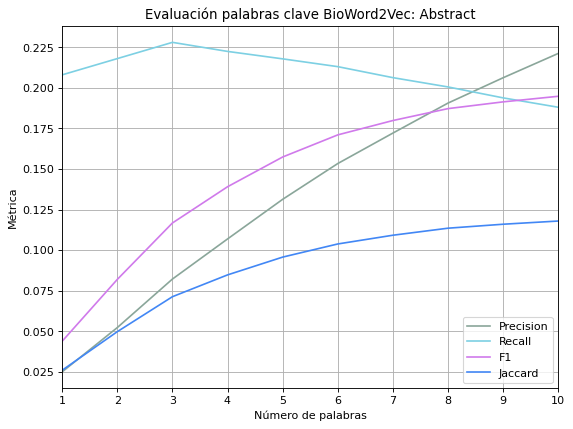

In [62]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,ac1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,ac2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,ac3, 'b', label='F1',c='#d07aeb')
plt.plot(x,ac4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave BioWord2Vec: Abstract')
plt.show()

## Modelo médico texto completo

In [63]:
key_word_list_bt=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_b)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in range(0, 10):
        keywords_list.append(clean_train_text[words])
 
    key_word_list_bt.append(keywords_list)

In [64]:
a=[]
ab1=[]
ab2=[]
ab3=[]
ab4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_bt[j][:i]
        e=evaluate_keywords(keys4[j],lista)
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    ab1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    ab2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    ab3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    ab4.append(aa4)

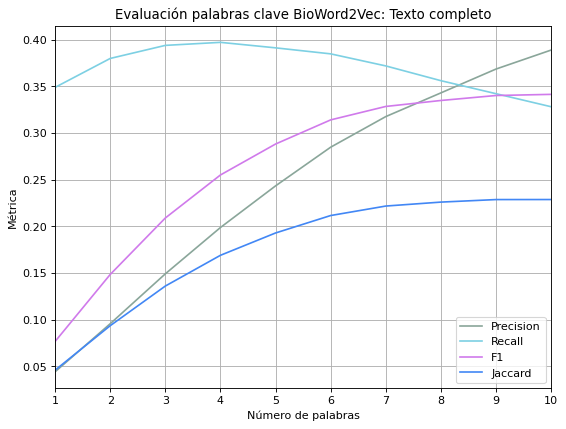

In [65]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,ab1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,ab2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,ab3, 'b', label='F1',c='#d07aeb')
plt.plot(x,ab4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave BioWord2Vec: Texto completo')
plt.show()